### Notebook to visualize the behavior of the agents

In [1]:
cd ../../

c:\Users\Yago\Desktop\GISD\TFG\code\cfe_rl


c:\Users\Yago\Desktop\GISD\TFG\code\cfe_rl\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from stable_baselines3 import DQN
from src.data import DataManager
from src.environments import DiscreteEnv, FlatToStartStepWrapper
from src.utils import load_model, plot_signal, predict_proba, l0_norm, num_subsequences

In [3]:
def calculate_cfe(x1, x2, mask):
    return np.where(mask, x2, x1)

### Setup

In [4]:
dataset = "ecg200"
exp = "fcn"
model = load_model(dataset, exp)
data = DataManager(f"UCR/{dataset}", model, "standard")
env = DiscreteEnv(data, model)
mapping_mode = "triangular"
discrete_env = FlatToStartStepWrapper(env, N=data.get_len(), mode=mapping_mode)
path_model = f"./results/dqn_prueba_{dataset}{'_2' if mapping_mode == 'triangular' else ''}.zip"
agent = DQN.load(path_model)

### Episode

In [5]:
obs, info = discrete_env.reset(train=False)
orig = obs["original"]
nun = obs["nun"]
mask = obs["mask"]
new = calculate_cfe(orig, nun, mask)

steps = [{"step": discrete_env.env.steps, "mask": discrete_env.env.mask.copy()}]
done, end = False, False
total_reward = 0

while not done and not end:
    action, _ = agent.predict(obs, deterministic=True)
    obs, reward, done, end, info = discrete_env.step(int(action))
    total_reward += reward
    steps.append({"step": discrete_env.env.steps, "mask": discrete_env.env.mask.copy()})

### Creating GIF

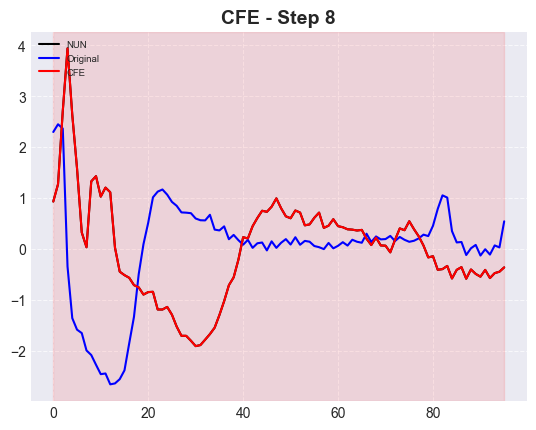

In [6]:
def init():
    ax.set_title("CFE")
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)


def update(frame):
    step_data = steps[frame]
    mask = step_data["mask"]
    plot_signal(orig, nun, mask, ax, dataset=f"Step {step_data['step']}")


plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots()
ani = animation.FuncAnimation(
    fig, update, frames=len(steps), init_func=init, repeat=False, interval=500
)
ani.save(f"./experiments/notebooks/{dataset}_{mapping_mode}.gif", writer="pillow")
plt.show()

### Animation

In [7]:
from IPython.display import HTML
HTML(ani.to_jshtml())

### Final info

In [8]:
final_cfe = calculate_cfe(orig, nun, discrete_env.env.mask)
print(f"Total reward = {total_reward}")
print(f"CFE proba = {predict_proba(model, final_cfe)[0]}")
print(f"% of change = {l0_norm(discrete_env.env.mask)/discrete_env.env.mask.size}")
print(f"Nº subsequences = {num_subsequences(discrete_env.env.mask)}")

Total reward = 0.0
CFE proba = tensor([[0.0038, 0.9962]])
% of change = 1.0
Nº subsequences = 1
